In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [66]:
import cudf as pd
import cupy as np
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [67]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   id        7613 non-null   int64
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [68]:
#dropping same tweets
train = train.drop_duplicates().reset_index(drop=True)

In [69]:
train.target.value_counts()
#data is a little biased towards 0(no disaster)

0    4342
1    3271
Name: target, dtype: int32

In [70]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: uint64

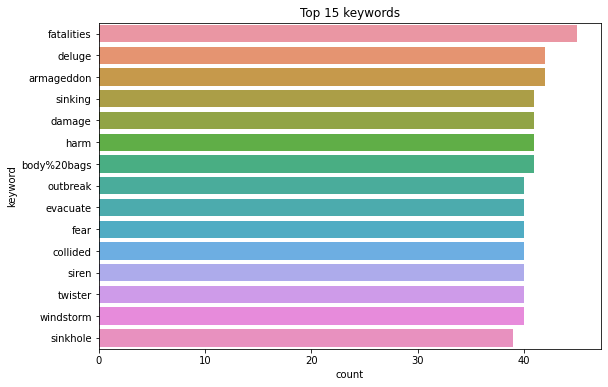

In [71]:
import pandas as pdn
import seaborn as sns
import matplotlib.pyplot as plt
Train = train.to_pandas()
plt.figure(figsize=(9,6))
sns.countplot(y=Train.keyword, order = Train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


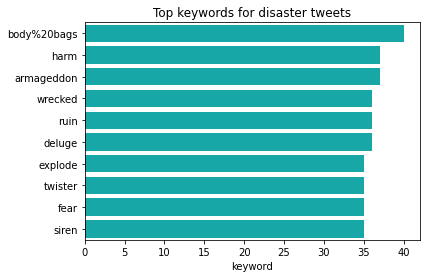

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


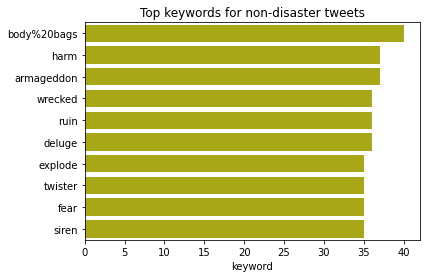

In [72]:
kw_nd = Train[Train.target==0].keyword.value_counts().head(10)


sns.barplot(kw_nd, kw_nd.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.show()
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

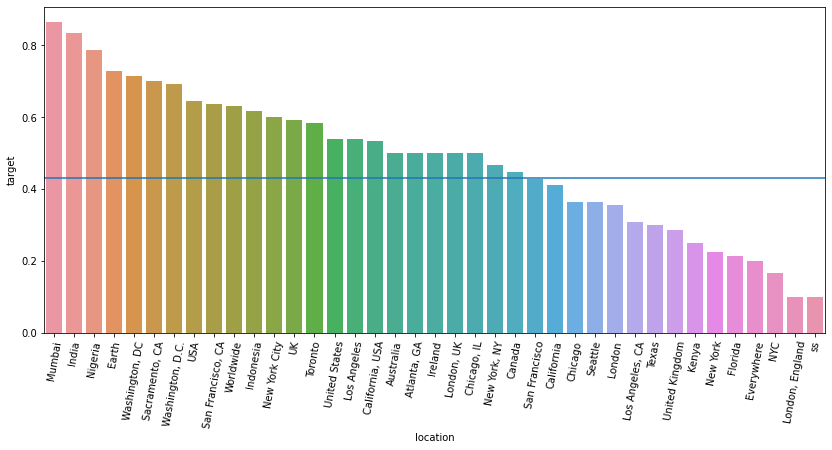

In [73]:
raw_loc = Train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = Train[Train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(Train.target))
plt.xticks(rotation=80)
plt.show()

In [74]:
import re
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text)           # Remove line breaks
    text = re.sub('\s+', ' ', text).strip()  # Remove leading, trailing, and extra spaces
    return text

In [75]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    List = []
    df1 = df['text'].to_frame().reset_index()
    for i in range(len(df1)) :
        x = df1.loc[i, "text"]
        List.append(clean_text(x))
    df['text_clean'] = List
    
    List = []
    for i in range(len(df1)) :
        x = df1.loc[i, "text"]
        List.append(find_hashtags(x))
    df['hashtags'] = List
    
    List = []
    for i in range(len(df1)) :
        x = df1.loc[i, "text"]
        List.append(find_mentions(x))
    df['mentions'] = List
    
    List = []
    for i in range(len(df1)) :
        x = df1.loc[i, "text"]
        List.append(find_links(x))
    df['links'] = List
        
    return df
    
train = process_text(train)
test = process_text(test)

In [76]:
type(train)

cudf.core.dataframe.DataFrame

In [77]:
import pandas as pdn
train = train.to_pandas()
test = test.to_pandas()
import category_encoders as ce

# Target encoding
features = ['keyword', 'location']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features],train['target'])

train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

In [78]:
#My count vectorizer is not working with cudf so i am using pandas for this step

import pandas as pdn
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pdn.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pdn.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pdn.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pdn.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pdn.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pdn.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [79]:
# Tf-idf for text
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train['text_clean'])
text_vec_test = vec_text.transform(test['text_clean'])
X_train_text = pdn.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pdn.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1691)


In [80]:
train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1833) (3263, 1832)


In [81]:
newDf = pd.DataFrame(train)

In [82]:
newTest = pd.DataFrame(test)

In [83]:
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','location','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = newDf.drop(columns = features_to_drop + ['target'])
X_test = newTest.drop(columns = features_to_drop)
y_train = newDf.target
# y_test = newTest.target

In [84]:
from cuml.linear_model import LogisticRegression
from cuml.multiclass import OneVsRestClassifier
cls = OneVsRestClassifier(LogisticRegression())
cls.fit(X_train.astype('float32'),y_train.astype('float32'))


OneVsRestClassifier()

In [85]:
y_pred = cls.predict(X_train.astype('float32'))

In [86]:
from sklearn.metrics import accuracy_score
y_train = pd.DataFrame(y_train)
y_train = y_train.values
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.values

accuracy_score(y_pred.get(),y_train.get())

0.844739261789045

In [ ]:
results = cls.predict(X_test.astype('float32'))
results

In [ ]:
submission_file = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission_file['target'] = results

In [ ]:
submission_file['target'] = submission_file['target'].astype('int64')
submission_file.info()

In [ ]:
submission_file.to_csv("submission_dslab.csv", index= False)

In [ ]:
from cuml.ensemble import RandomForestClassifier as cuRFC
RFC_model = cuRFC(max_features=1.0,
                   n_bins=10,
                   n_estimators=100)
RFC_model.fit(X_train.astype('float32'),y_train.astype('float32'))
RFC_predict = RFC_model.predict(X_test.astype('float32'))

In [ ]:
submission_file = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission_file['target'] = RFC_predict
submission_file['target'] = submission_file['target'].astype('int64')
submission_file.info()


In [ ]:
submission_file.to_csv("submission_rfc2.csv", index= False)